<a href="https://colab.research.google.com/github/camlab-bioml/2021_IMC_Jett/blob/main/DAMM_081221.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.optim as optim
import torch.distributions as D
import torch.nn.functional as F

import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

from matplotlib.backends.backend_pdf import PdfPages

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

import seaborn as sns

%matplotlib inline

In [2]:
## generate data
def generateData(n_clusters = 3, n_obs = 10000, n_features = 2):

  #n_clusters = 3; n_obs = 100; n_features = 2
  
  ## set truth expression means/covariances (multivariate) ##
  mu = np.random.rand(n_clusters, n_features)
  # mu = np.sort(mu, 0) ## sort expressions
  sigma = 0.001 * np.identity(n_features) ## variance-covariance matrix

  ## set truth cell size means/variances (univariate) ##
  psi = [np.random.normal(100, 25) for i in range(n_clusters)]
  #psi = np.arange(90, 90 + 5 * n_clusters, 5)
  psi = np.sort(psi, 0)
  omega = 1 ## standard deviation
  ###

  ## set latent variables distributions ##
  lambda_arr = np.random.binomial(1, .95, n_obs) # p=.95 (a cell belongs to singlet or doublet) 

  n_singlet = np.sum(lambda_arr == 1) ## number of cells in singlet clusters
  n_doublet = np.sum(lambda_arr == 0) ## number of cells in doublet clusters
  
  lambda0_arr = n_singlet / n_obs ## proportion of cells belong to singlet
  lambda1_arr = n_doublet / n_obs ## proportion of cells belong to doublet

  #pi_arr = np.sort(np.random.sample(n_clusters))
  pi_arr = np.sort(np.random.rand(n_clusters))
  pi_arr /= pi_arr.sum()

  n_doublet_clusters = int((n_clusters * n_clusters - n_clusters)/2 + n_clusters)
  #tau_arr = np.sort(np.random.sample(n_doublet_clusters))
  tau_arr = np.sort(np.random.rand(n_doublet_clusters))
  tau_arr /= tau_arr.sum()

  ## draw cells based on defined parameters theta1 = (mu, sigma, psi, omega) & theta2 = (lambda, pi, tau)
  x = np.zeros((n_singlet, n_features+5))
  for i in range(n_singlet):
    selected_cluster = np.random.choice(n_clusters, size = 1, p = pi_arr)[0] ## select a single cell cluster
    x[i] = np.append(np.random.multivariate_normal(mu[selected_cluster], sigma),
                     [np.random.normal(psi[selected_cluster], omega), 
                      0, selected_cluster, 0, selected_cluster + n_doublet_clusters])
  
  x[x < 0] = 1e-4
  lookups = np.triu_indices(n_clusters) # wanted indices
  xx = np.zeros((n_doublet, n_features+5))
  for i in range(n_doublet):
    selected_cluster = np.random.choice(n_doublet_clusters, p = tau_arr)

    indx1 = lookups[0][selected_cluster]
    indx2 = lookups[1][selected_cluster]

    xx[i] = np.append(np.random.multivariate_normal( (mu[indx1] + mu[indx2])/2, (sigma + sigma)/2 ),
                     [np.random.normal( (psi[indx1] + psi[indx2]), omega+omega ), 
                      1, indx1, indx2, selected_cluster])
  xx[xx < 0] = 1e-4
  xxx = np.append(x, xx).reshape(n_obs, n_features+5)

  return torch.tensor(xxx[:,:n_features]), torch.tensor(xxx[:,n_features]), torch.tensor(xxx), [mu, sigma, psi, omega], [lambda0_arr, pi_arr, tau_arr]

In [3]:
nt = 5 # number of trials?
nc = 5 # number of clusters?
nf = 20 # number of proteins
no = 1000 # number of cells
N_ITER_EM = 100
N_ITER_OPT = 100
lr = 1e-3
tol = 1e-4


Y, S, XX, theta0, theta1 = generateData(nc, no, nf)


YY = Y.numpy()
XX = XX.numpy()
SS = S.numpy()

In [5]:
mu_true = theta0[0]

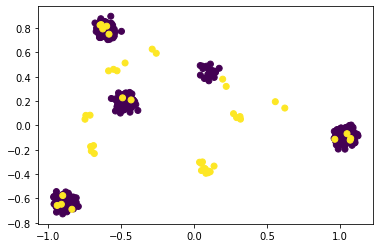

In [4]:
pca = PCA(n_components=2)
Z = pca.fit_transform(YY)

is_doublet = XX[:,21]

cl1 = XX[:,22]
cl2 = XX[:,23]

plt.scatter(Z[:,0], Z[:,1], c=is_doublet);

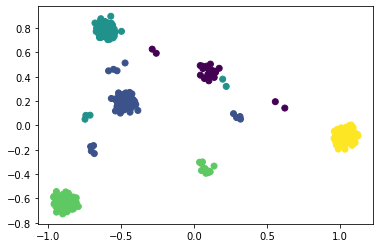

In [6]:
plt.scatter(Z[:,0], Z[:,1], c=cl1);

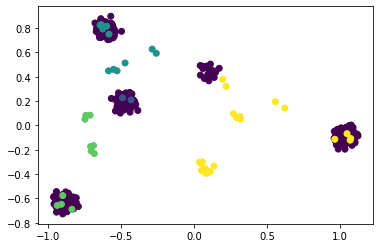

In [7]:
plt.scatter(Z[:,0], Z[:,1], c=cl2);

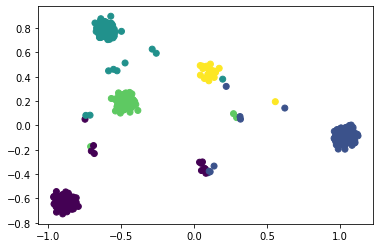

In [8]:
N_INIT = 5

kms = [KMeans(nc).fit(YY) for i in range(N_INIT)]
inertias = [k.inertia_ for k in kms]
km = kms[np.argmin(np.array(inertias))]
init_labels = km.labels_

plt.scatter(Z[:,0], Z[:,1], c=init_labels);

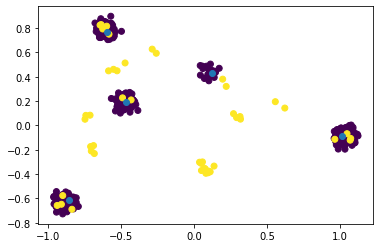

In [12]:
mu_init = np.array([YY[init_labels == i,:].mean(0) for i in np.unique(init_labels)])
sigma_init = np.array([YY[init_labels == i,:].std(0) for i in np.unique(init_labels)])
psi_init = np.array([SS[init_labels == i].mean() for i in np.unique(init_labels)])
omega_init = np.array([SS[init_labels == i].std() for i in np.unique(init_labels)])
pi_init = np.array([np.mean(init_labels == i) for i in np.unique(init_labels)])
tau_init = np.ones((nc,nc))
tau_init = tau_init / tau_init.sum()

Z_mu_init = pca.transform(mu_init)

plt.scatter(Z[:,0], Z[:,1], c=is_doublet);
plt.scatter(Z_mu_init[:,0], Z_mu_init[:,1]);

In [13]:
def compute_p_y_given_z(Y, Theta):
  """ Returns NxC
  p(y_n | z_n = c)
  """
  mu = torch.exp(Theta['log_mu'])
  sigma = torch.exp(Theta['log_sigma'])

  dist_Y = D.Normal(mu, sigma)
  return dist_Y.log_prob(Y.reshape(no, 1, nf)).sum(2) # <- sum because IID over G

def compute_p_s_given_z(S, Theta):
  """ Returns NxC
  p(s_n | z_n = c)
  """
  psi = torch.exp(Theta['log_psi'])
  omega = torch.exp(Theta['log_omega'])

  dist_S = D.Normal(psi, omega)
  return dist_S.log_prob(S.reshape(-1,1)) 

def compute_p_y_given_gamma(Y, Theta):
  """ NxCxC
  p(y_n | gamma_n = [c,c'])
  """

  mu = torch.exp(Theta['log_mu'])
  sigma = torch.exp(Theta['log_sigma'])

  mu2 = mu.reshape(1, nc, nf)
  mu2 = (mu2 + mu2.permute(1, 0, 2)) / 2.0 # C x C x G matrix 

  sigma2 = sigma.reshape(1, nc, nf)
  sigma2 = (sigma2 + sigma2.permute(1,0,2)) / 2.0

  dist_Y2 = D.Normal(mu2, sigma2)
  return  dist_Y2.log_prob(Y.reshape(-1, 1, 1, nf)).sum(3) # <- sum because IID over G

def compute_p_s_given_gamma(Y, Theta):
  """ NxCxC
  p(s_n | gamma_n = [c,c'])
  """
  psi = torch.exp(Theta['log_psi'])
  omega = torch.exp(Theta['log_omega'])

  psi2 = psi.reshape(-1,1)
  psi2 = psi2 + psi2.T

  omega2 = omega.reshape(-1,1)
  omega2 = omega2 + omega2.T

  dist_S2 = D.Normal(psi2, omega2)
  return dist_S2.log_prob(S.reshape(-1, 1, 1))

def compute_r_v_2(Y, S, Theta):
  """Need to compute
  p(gamma = [c,c'], d= 1 | Y,S)
  p(z = c, d=0 | Y,S)
  """
  log_pi = F.log_softmax(Theta['is_pi'])
  log_tau = F.log_softmax(Theta['is_tau'].reshape(-1)).reshape(nc,nc)
  log_delta = F.log_softmax(Theta['is_delta'])

  p_y_given_z = compute_p_y_given_z(Y, Theta)
  p_s_given_z = compute_p_s_given_z(S, Theta)

  p_data_given_z_d0 = p_y_given_z + p_s_given_z + log_pi
  p_data_given_d0 = torch.logsumexp(p_data_given_z_d0, dim=1) # this is p(data|d=0)

  p_y_given_gamma = compute_p_y_given_gamma(Y, Theta)
  p_s_given_gamma = compute_p_s_given_gamma(Y, Theta)

  p_data_given_gamma_d1 = (p_y_given_gamma + p_s_given_gamma + log_tau).reshape(no, -1)

  # p_data_given_d1 = torch.logsumexp(p_data_given_gamma_d1, dim=1)

  p_data = torch.cat([p_data_given_z_d0 + log_delta[0], p_data_given_gamma_d1 + log_delta[1]], dim=1)
  p_data = torch.logsumexp(p_data, dim=1)

  r = p_data_given_z_d0.T + log_delta[0] - p_data
  v = p_data_given_gamma_d1.T + log_delta[1] - p_data

  p_singlet = torch.exp(p_data_given_d0 + log_delta[0] - p_data)

  return r.T, v.T.reshape(-1,nc,nc), p_data, p_singlet


In [14]:
def Q(Theta, Y, S, r, v, ignored_indices):

  log_pi = F.log_softmax(Theta['is_pi'])
  log_tau = F.log_softmax(Theta['is_tau'].reshape(-1)).reshape(nc,nc)
  log_delta = F.log_softmax(Theta['is_delta'])

  p_y_given_z = compute_p_y_given_z(Y, Theta)
  p_s_given_z = compute_p_s_given_z(S, Theta)

  log_rd0z = p_s_given_z + p_y_given_z + log_pi + log_delta[0]

  p_y_given_gamma = compute_p_y_given_gamma(Y, Theta)
  p_s_given_gamma = compute_p_s_given_gamma(Y, Theta)

  log_rd1g = p_y_given_gamma + p_s_given_gamma + log_tau + log_delta[1] # can use torch.triu to get upper triangle


  q1 = log_rd0z * r.exp() #; q1[torch.isnan(q1)] = 0.0
  q2 = log_rd1g * v.exp() #; q2[torch.isnan(q2)] = 0.0

  return q1.sum() + q2.sum()

def LL(Theta, v):
    """
    returns L(\mathbf\Theta, \mathbf{Y}, \mathbf{s}, \mathbf{r}, \mathbf{v})
    """
    l1 = rd0z.T + r
    l2 = rd1g[~ignored_indices].T + v[:,~ignored_indices]; #l2[torch.isinf(l2)] = -100
    ll = torch.vstack((torch.logsumexp(l1,1), torch.logsumexp(l2,1))).logsumexp(0).mean()

    return ll

In [18]:
# [lambda_d0, pi, tau, psi, omega, mu, sigma]
"""
Theta has order:
1) lambda_d0
2) pi
3) tau
4) psi
5) omega
6) mu
7) sigma
"""

## Helper functions:

def inverse_sigmoid(x):
  return -np.log((1 / (x + 1e-8)) - 1)

## Exact Theta:
# Theta = {
#     'log_mu': np.log(mu_init),
#     'log_sigma': np.log(sigma_init),
#     'log_psi': np.log(psi_init),
#     'log_omega': np.log(omega_init),
#     "is_delta": np.log([0.95, 1-0.95]),
#     'is_pi': np.log(pi_init),
#     'is_tau': np.log(tau_init)
# }

## Very slightly corrupted theta:
Theta = {
    'log_mu': np.log(mu_init) + 0.05 * np.random.randn(mu_init.shape[0], mu_init.shape[1]),
    'log_sigma': np.log(sigma_init), #np.zeros_like(sigma_init),
    'log_psi': np.log(psi_init),
    'log_omega': np.log(omega_init),
    "is_delta": np.log([0.95, 1-0.95]),
    'is_pi': np.log(pi_init),
    'is_tau': np.log(tau_init)
}

In [19]:
Theta = {k: torch.tensor(v, requires_grad=True) for (k,v) in Theta.items()}

0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to 

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


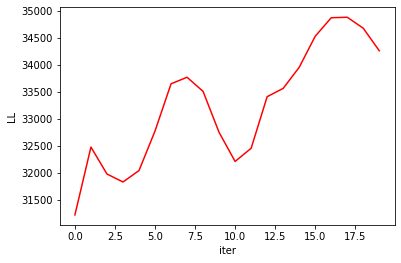

In [21]:
nt = 5
nc = 5
nf = 20
no = 1000
N_ITER_EM = 20
N_ITER_OPT = 100
lr = 1e-3
tol = 1e-4

  
ls = []
qs = []

# Y, S, XX, theta0, theta1 = generateData(nc, no, nf)


# Theta now Theta.values()
# opt = optim.Adam([Theta['log_mu']], lr=lr)
opt = optim.Adam(Theta.values(), lr=lr)
for i in range(N_ITER_EM):

  print(i)

  opt.zero_grad()

  # E Step:
  with torch.no_grad():
    r,v,L, p_singlet = compute_r_v_2(Y, S, Theta)
    # if i == 0:
    #   print(LL(Theta, rd0z, r, rd1g, v, ignored_indices))

  # M step (i.e. maximizing Q):
  for j in range(N_ITER_OPT):

    q = -Q(Theta, Y, S, r, v, None)
    # print(q)
    q.backward()
    opt.step()

    # n_c = torch.sum(torch.exp(r), dim=0)
    # Theta[1] = n_c / no #lambda_d0
    # Theta[0] = torch.sum(Theta[1]) #pi
    # #print(Theta[1])

    # n_cc = torch.sum(torch.exp(v).reshape(no, nc, nc), dim=0)
    # Theta[2] = n_cc / no #tau

  # Check for convergence
  with torch.no_grad():
    # ll = LL(Theta, rd0z, r, rd1g, v, ignored_indices)
    ll = L.detach() # Q(Theta, Y, S, r, v, None)
  
    #if i > 0 and abs(ls[-1] - ll) < tol:
    #  break
  
    qs.append(-q.detach())
    ls.append(L.sum())
  
plt.plot(ls, 'r'); plt.xlabel("iter"); plt.ylabel("LL"); plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


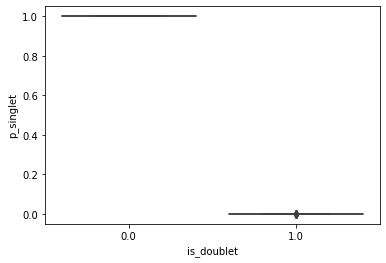

In [ ]:
with torch.no_grad():
  r,v, L, p_singlet = compute_r_v_2(Y,S,Theta)

df_singlet = pd.DataFrame({
    "is_doublet": is_doublet.astype(str),
    "p_singlet": p_singlet.numpy().astype(float)
})

sns.boxplot(data=df_singlet, x = 'is_doublet', y = 'p_singlet')


In [ ]:
mu_true

mu_inferred = torch.exp(Theta['log_mu'].detach()).numpy()

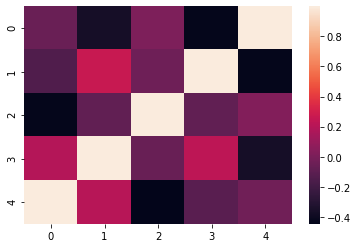

In [ ]:
sns.heatmap(np.corrcoef(mu_true, mu_inferred)[0:5,5:])


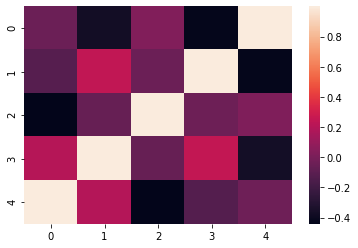

In [ ]:
sns.heatmap(np.corrcoef(mu_true, mu_init)[0:5,5:])

973

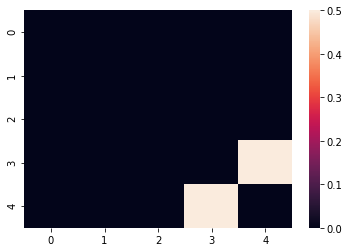

In [ ]:
vv = v.detach().numpy()
sns.heatmap(np.exp(vv[df_singlet.p_singlet.argmin(),:,:]))